##Modell zur Optimierung

In [149]:
#imports
import pulp as p
from pulp import value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from demandlib import bdew
from geopy.geocoders import Nominatim
import requests
import os
import logging
from bs4 import BeautifulSoup
from entsoe import EntsoePandasClient
from datetime import datetime 
import configparser
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import calendar
import tkinter as tk
from tkinter import ttk

In [ ]:
#Gui erstellen für das Eingeben der Werte


# Globales Dictionary für die gespeicherten Werte
saved_values = {}

def create_label_entry(parent, label_text, entries_dict):
    label = tk.Label(parent, text=label_text)
    label.pack(anchor="w", pady=2)
    entry = tk.Entry(parent)
    entry.pack(fill="x", pady=2)
    entries_dict[label_text] = entry
    return entry

def main():
    global saved_values  # Zugriff auf das globale saved_values-Dictionary

    # Hauptfenster erstellen
    root = tk.Tk()
    root.title("Wärmepumpe")
    root.geometry("1920x1080")

    # Dictionary für Eingabefelder
    entries = {}

    # Notebook (Tab-Container) erstellen
    notebook = ttk.Notebook(root)
    notebook.pack(expand=True, fill="both")

    # Tab 1: Wärmepumpe
    tab_wp = ttk.Frame(notebook)
    notebook.add(tab_wp, text="Wärmepumpe")

    wp_fields = [
        "Wärmedurchgangskoeffizient_Wand",
        "Fläche_der_Wand",
        "Wärmedurchgangskoeffizient_Fenster",
        "Fläche_der_Fenster",
        "Raumvolumen",
        "Luftwechselrate",
        "Dichte_der_Luft",
        "Wärmekapazität_der_Luft",
        "gewünschte_Innentemperatur",
        "COP_Vorfaktor",
        "Steigung",
        "Basiswert"
    ]

    for field in wp_fields:
        create_label_entry(tab_wp, field, entries)

    # Tab 2: Basis Model
    tab_bm = ttk.Frame(notebook)
    notebook.add(tab_bm, text="Basis Model")

    bm_fields = [
        "P_bat",
        "E_bat",
        "eta_bat",
        "c_pur",
        "c_feedin",
        "l_start"
    ]

    for field in bm_fields:
        create_label_entry(tab_bm, field, entries)

    # Funktion, um alle Eingaben zu speichern und drucken
    def on_close():
        global saved_values  # Zugriff auf das globale Dictionary

        # Alle Eingabewerte durchgehen und in saved_values speichern
        for key, entry in entries.items():
            entry_value = entry.get()  # Wert aus dem Eingabefeld holen
            saved_values[key] = entry_value  # Wert im Dictionary speichern

        # Das Programm beenden
        root.destroy()

    # Schließen-Event binden
    root.protocol("WM_DELETE_WINDOW", on_close)

    # GUI-Loop starten
    root.mainloop()

if __name__ == "__main__":
    main()

## Definition von Parametern

In [217]:
p_max = 10 # Maximale Leistung Wärmepumpe
s_max = 7 # Maximale Kapazität Pufferspeicher
s_laden = 3 # Maximale Ladeleistung Pufferspeicher
s_entladen = 1 # Maximale Entladeleistung Pufferspeicher
eta_puf = 0.95 # Wirkungsgrad Pufferspeicher beim Einspeisen
loss_puf = 0.02 # Wärmeverlust pro Zeiteinheit in Prozent

dt = 1  # Stunde
S_start = 0  # Anfangsfüllstand des Wärmespeichers

U_wand = 0.3  # Wärmedurchgangskoeffizient Wand (W/m²K)
A_wand = 90   # Fläche der Wand (m²)
U_fenster = 1.2  # Wärmedurchgangskoeffizient Fenster (W/m²K)
A_fenster = 22   # Fläche der Fenster (m²)
V_raum = 340     # Raumvolumen (m³)
luftwechselrate = 0.5  # Luftwechselrate (1/h)
rho = 1.2        # Dichte der Luft (kg/m³)
c = 1000         # Wärmekapazität der Luft (J/kgK)
temp_innen = 20 # Gewünschte Innentemperatur in Grad
cop_vorfaktor = 0.4 #
a = 1.5  # Steigung Heizkurve
b = 30  # Basiswert

P_bat = 10 # Maximale Lade- & Entladeleistung Batterie in kW
E_bat = 20 # Maximale Kapazität Batterie in kW
eta_bat = 0.9 # Wirkungsgrad Batterie
c_pur = 0.059  # Strompreis in EUR/kWh
c_feedin = 0.018  # Einspeisevergütung EUR/kWh Einspeisen
l_start = 0  # Anfangsfüllstand der Batterie in kW
yearly_demand = 3000 # kWh
pv_installed_power = 10 # kWp
selected_location = "Universitätsstraße 12, 45141 Essen"
selected_year = 2019

buy_pump = 6000 # Anschaffungskosten Wärmepumpe in Euro
buy_storage = 7800 # Anschaffungskosten Pufferspeicher in Euro
heating_bill = 1730 # Jährliche Heizkostenrechnung

In [218]:
# Erstelle Erzeugungsprofil für PV-Anlage

geolocator = Nominatim(user_agent="EuerName")
location = geolocator.geocode(selected_location)


# API-Abfrage
url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

# Parameter
params = {
    "lat": location.latitude,
    "lon": location.longitude,
    "startyear": selected_year,
    "endyear": selected_year,
    "pvcalculation": 1,
    "peakpower": pv_installed_power,    # kWp
    "loss": 10,
    "outputformat": "json",
}

# Abfrage
r = requests.get(url, params=params)
data = r.json()

# Erstelle DataFrame
elec_pv = pd.DataFrame(data["outputs"]["hourly"])
elec_pv.index = pd.to_datetime(elec_pv["time"], format="%Y%m%d:%H10")
# remove all columns except "P"
elec_pv = elec_pv[["P"]]

In [ ]:
# Daten abfragen
# Start- und Endjahr für die Datenabfrage (inklusive Startjahr, exklusive Endjahr) 
# Daten sind nur von 2019 bis 2025 verfügbar
startyear = 2019
endyear = 2025

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

def load_config(): 
    config = configparser.ConfigParser()
    config.read('config.ini')
    config = {
        "api_key": config["API"]["api_key"],
    }
    return config

# API-Key aus der Konfigurationsdatei laden
api_key = load_config()["api_key"]
if not api_key:
    logger.error("API-Schlüssel für ENTSO-E nicht gefunden.")
    exit(1)

client = EntsoePandasClient(api_key=api_key)

# Funktion zum Abrufen der Wetterdaten
def gettable(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'class': 'uk-table uk-table-condensed table_extremwerte'})
        if not table:
            raise ValueError("Tabelle nicht gefunden.")
        
        rows = table.find_all('tr')
        data = []
        for row in rows[1:]:
            cols = row.find_all('td')
            data.append([ele.text.strip() for ele in cols])
        
        columns = ['Datum', 'MinTemp', 'MaxTemp', 'Durchschnitt', 'Niederschlag', 'Wind', 'Sonnenstunden', 'NachtTemp']
        return pd.DataFrame(data, columns=columns)
    except Exception as e:
        logger.error(f"Fehler beim Abrufen der Wetterdaten von {url}: {e}")
        return None

# Funktion, um DataFrame auf Stundenbasis zu erweitern
def expand_to_hours(df):
    expanded_data = []
    for _, row in df.iterrows():
        datum = pd.to_datetime(row['Datum'], format='%d.%m.%Y')
        min_temp = float(row['MinTemp'])
        max_temp = float(row['MaxTemp'])
        
        for hour in range(24):
            timestamp = datum + pd.Timedelta(hours=hour)
            estimated_temp = min_temp + (max_temp - min_temp) * np.sin(np.pi * (hour - 5) / 24)**2
            expanded_data.append({
                'Zeitstempel': timestamp,
                'Geschätzte Temperatur': estimated_temp,
                'Datum': row['Datum'],
                'MinTemp': row['MinTemp'],
                'MaxTemp': row['MaxTemp'],
                'Durchschnitt': row['Durchschnitt']
            })
    return pd.DataFrame(expanded_data)

# Funktion zum Abrufen der Strompreisdaten
def fetch_electricity_prices(year):
    startdate = f'{year}-01-01'
    enddate = f'{year+1}-01-01'
    
    start = pd.Timestamp(startdate, tz='Europe/Brussels')
    end = pd.Timestamp(enddate, tz='Europe/Brussels')
    
    try:
        day_ahead_prices = client.query_day_ahead_prices('DE_LU', start=start, end=end)
        day_ahead_prices_df = day_ahead_prices.reset_index()
        day_ahead_prices_df.columns = ['Datum_Uhrzeit', 'Day_ahead_prices']
        day_ahead_prices_df['Strompreis'] = (day_ahead_prices_df['Day_ahead_prices'] / 1000) / 0.3
        day_ahead_prices_df.drop(columns=['Day_ahead_prices'], axis=1, inplace=True)
        return day_ahead_prices_df
    except Exception as e:
        logger.error(f"Fehler beim Abrufen der Strompreise für {year}: {e}")
        return pd.DataFrame()

# Abruf der Wetterdaten
def fetch_weather_data(year):
    all_years_data = []
    for month in range(1, 13):
        start_date = f"{year}-{month:02d}-01"
        end_date = pd.Timestamp(f"{year}-{month+1:02d}-01") - pd.Timedelta(days=1) if month < 12 else pd.Timestamp(f"{year+1}-01-01") - pd.Timedelta(days=1)
        
        url = f"https://www.wetterkontor.de/de/wetter/deutschland/rueckblick.asp?id=55&datum0={start_date}&datum1={end_date}&jr={year}&mo={month}&datum=08.01.2025&t=4&part=1"
        
        df_month = gettable(url)
        if df_month is not None:
            df_month = df_month.drop(columns=['Niederschlag', 'Wind', 'Sonnenstunden', 'NachtTemp'])
            df_month.sort_values(by='Datum', inplace=True)
            all_years_data.append(df_month)
    
    return pd.concat(all_years_data, ignore_index=True) if all_years_data else pd.DataFrame()

# Funktion zum parallelen Abrufen von Wetter- und Strompreisdaten
def fetch_all_data():
    all_weather_data = []
    all_electricity_data = []

    with ThreadPoolExecutor() as executor:
        weather_future = {executor.submit(fetch_weather_data, year): year for year in range(startyear, endyear)}
        electricity_future = {executor.submit(fetch_electricity_prices, year): year for year in range(startyear, endyear)}

        # Ergebnisse abwarten
        for future in weather_future:
            try:
                result = future.result()  # Call result on the future itself
                if not result.empty:
                    all_weather_data.append(result)
            except Exception as e:
                logger.error(f"Fehler beim Abrufen der Wetterdaten für Jahr {weather_future[future]}: {e}")

        for future in electricity_future:
            try:
                result = future.result()  # Call result on the future itself
                if not result.empty:
                    all_electricity_data.append(result)
            except Exception as e:
                logger.error(f"Fehler beim Abrufen der Strompreisdaten für Jahr {electricity_future[future]}: {e}")

    return pd.concat(all_weather_data, ignore_index=True) if all_weather_data else pd.DataFrame(), pd.concat(all_electricity_data, ignore_index=True) if all_electricity_data else pd.DataFrame()

# Hauptlogik
final_weather_data, final_electricity_data = fetch_all_data()

if not final_weather_data.empty and not final_electricity_data.empty:
    # Entfernen von Zeilen ohne gültiges Datum
    final_weather_data = final_weather_data.dropna(subset=['Datum'])
    final_weather_data = final_weather_data[final_weather_data['Datum'].notna() & (final_weather_data['Datum'] != "")]

    # Entfernen von Einheiten und Umwandeln der Temperaturwerte
    final_weather_data['MinTemp'] = final_weather_data['MinTemp'].str.replace(',', '.').astype(float)
    final_weather_data['MaxTemp'] = final_weather_data['MaxTemp'].str.replace(',', '.').astype(float)
    
    expanded_weather_df = expand_to_hours(final_weather_data)
    expanded_weather_df.drop(columns=['Datum', 'MinTemp', 'MaxTemp', 'Durchschnitt'], inplace=True)

    expanded_weather_df['Zeitstempel'] = pd.to_datetime(expanded_weather_df['Zeitstempel'], errors='coerce', utc=True).dt.tz_localize(None)
    final_electricity_data['Datum_Uhrzeit'] = pd.to_datetime(final_electricity_data['Datum_Uhrzeit'], errors='coerce', utc=True).dt.tz_localize(None)

    # Merge und Füllen der fehlenden Strompreise
    merged_df = pd.merge(expanded_weather_df, final_electricity_data, left_on='Zeitstempel', right_on='Datum_Uhrzeit', how='left')
    merged_df.drop(columns=['Datum_Uhrzeit'], inplace=True)
    merged_df['Strompreis'] = merged_df['Strompreis'].fillna(method='ffill').fillna(method='bfill')

    # Entfernen von Duplikaten und umbennenen des dataframes
    Wetter_und_Strompreis_df = merged_df.drop_duplicates(keep='first')
else:
    logger.error("Fehler: Wetter- oder Strompreisdaten konnten nicht abgerufen werden.")


df_basisModel = elec_pv
# Spalte unamed in Zeitstempel umbenennen
df_basisModel.rename(columns={'Unnamed: 0': 'Zeitstempel'}, inplace=True)
# Spalte Zeitstempel in Datetime umwandeln
df_basisModel['Zeitstempel'] = pd.to_datetime(df_basisModel['Zeitstempel'], errors='coerce', utc=True).dt.tz_localize(None)

# Daten aus Basis-Modell Wetter und Strom  joinen,
df_2019 = pd.merge(df_basisModel, merged_df, on='Zeitstempel', how='left')
# Duplikate entfernen
df_2019 = df_2019.drop_duplicates(keep='first')

In [ ]:
# Visualisierung der Daten

# Konvertiere die Zeitstempel in pandas DateTime für die Filterung nach Jahreszeit
df_2019['Zeitstempel'] = pd.to_datetime(df_2019['Zeitstempel'])

# Spalte für Monat hinzufügen
df_2019['Monat'] = df_2019['Zeitstempel'].dt.month

# Filter für Sommer- und Wintermonate
sommermonate = [6, 7, 8]
wintermonate = [12, 1, 2]

# Durchschnittlicher Tagesablauf im Sommer und Winter
df_sommer = df_2019[df_2019['Monat'].isin(sommermonate)].copy()
df_winter = df_2019[df_2019['Monat'].isin(wintermonate)].copy()

df_sommer['Stunde'] = df_sommer['Zeitstempel'].dt.hour
df_winter['Stunde'] = df_winter['Zeitstempel'].dt.hour

# Gruppieren nach Stunde und Durchschnitt berechnen
sommer_avg = df_sommer.groupby('Stunde')[['Geschätzte Temperatur', 'Strompreis']].mean()
winter_avg = df_winter.groupby('Stunde')[['Geschätzte Temperatur', 'Strompreis']].mean()

# Konvertiere die Zeitstempel in pandas DateTime für die Filterung nach Datum
df_2019['Zeitstempel'] = pd.to_datetime(df_2019['Zeitstempel'])

# Ein bestimmter Tag im Sommer (z. B. 15. Juli 2019) und Winter (z. B. 15. Januar 2019)
sommer_tag = '2019-06-15'
winter_tag = '2019-01-15'

# Filtern der Daten für den Sommer- und Wintertag
df_sommer_tag = df_2019[df_2019['Zeitstempel'].dt.date == pd.to_datetime(sommer_tag).date()]
df_winter_tag = df_2019[df_2019['Zeitstempel'].dt.date == pd.to_datetime(winter_tag).date()]

# Temperatur-Tagesverlauf (Sommer)
plt.figure(figsize=(15, 5))
plt.plot(df_sommer_tag['Zeitstempel'].dt.hour, df_sommer_tag['Geschätzte Temperatur'], label='Temperatur', color='orange')
plt.title(f'Temperaturverlauf am {sommer_tag} (Sommer)')
plt.xlabel('Stunde')
plt.ylabel('Temperatur (°C)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Temperatur-Tagesverlauf (Winter)
plt.figure(figsize=(15, 5))
plt.plot(df_winter_tag['Zeitstempel'].dt.hour, df_winter_tag['Geschätzte Temperatur'], label='Temperatur', color='blue')
plt.title(f'Temperaturverlauf am {winter_tag} (Winter)')
plt.xlabel('Stunde')
plt.ylabel('Temperatur (°C)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Strompreis-Tagesverlauf (Sommer)
plt.figure(figsize=(15, 5))
plt.plot(df_sommer_tag['Zeitstempel'].dt.hour, df_sommer_tag['Strompreis'], label='Strompreis', color='red')
plt.title(f'Strompreisverlauf am {sommer_tag} (Sommer)')
plt.xlabel('Stunde')
plt.ylabel('Strompreis (€)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Strompreis-Tagesverlauf (Winter)
plt.figure(figsize=(15, 5))
plt.plot(df_winter_tag['Zeitstempel'].dt.hour, df_winter_tag['Strompreis'], label='Strompreis', color='purple')
plt.title(f'Strompreisverlauf am {winter_tag} (Winter)')
plt.xlabel('Stunde')
plt.ylabel('Strompreis (€)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Visualisierung des Jahresverlaufs
df_2019['Monatstag'] = df_2019['Zeitstempel'].dt.strftime('%m-%d')
jahresverlauf = df_2019.groupby('Monatstag')[['Geschätzte Temperatur', 'Strompreis']].mean()

# Erstelle eine Liste mit Positionen und Labels für jeden Monat
monat_labels = [f"{month:02d}-15" for month in range(1, 13)]  # Mitte jedes Monats
monat_positionen = [jahresverlauf.index.get_loc(label) for label in monat_labels if label in jahresverlauf.index]

# Temperatur-Diagramm
plt.figure(figsize=(15, 5))
plt.plot(jahresverlauf.index, jahresverlauf['Geschätzte Temperatur'], label='Temperatur (Jahresverlauf)', color='green')
plt.title('Jahresverlauf der Temperatur')
plt.xlabel('Monat')
plt.ylabel('Temperatur (°C)')
plt.xticks(ticks=monat_positionen, labels=[calendar.month_name[int(label.split('-')[0])] for label in monat_labels], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Strompreis-Diagramm
plt.figure(figsize=(15, 5))
plt.plot(jahresverlauf.index, jahresverlauf['Strompreis'], label='Strompreis (Jahresverlauf)', color='brown')
plt.title('Jahresverlauf der Strompreise')
plt.xlabel('Monat')
plt.ylabel('Strompreis (€)')
plt.xticks(ticks=monat_positionen, labels=[calendar.month_name[int(label.split('-')[0])] for label in monat_labels], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [219]:
# Außentemperaturen (°C) für jede Stunde
T_aussen = df_2019['Geschätzte Temperatur'].values

# Strompreise
Strompreise = df_2019['Strompreis'].values

# Elektrische Nachfrage des Haushalts ohne Wärmepumpe (kW) für jede Stunde
D_Haushalt = df_2019['demand'].values

# Berechnung der PV-Erzeugung (kW)
PV = df_2019['pv'].values

# Zeitraumlänge in Stunden
T = int(len(df_2019['Strompreis']))

# Wärmepumpemodell

## Rechnungen zur Vorbereitung der Daten für das Wärmepumpemodell

---

## Berechnung der Heizlast


### 1. Temperaturunterschied

Die Temperaturdifferenz zwischen Innen- und Außentemperatur berechnet sich wie folgt:

$$
\Delta T = T_{\text{innen}} - T_{\text{außen}}
$$

---

### 2. Negative Werte durch 0 ersetzen

Falls die berechnete Temperaturdifferenz negativ ist, wird sie auf 0 gesetzt:

$$
\Delta T = \max(\Delta T, 0)
$$

---

### 3. Transmissionswärmeverluste

Für die Transmissionswärmeverluste durch Wand und Fenster sowie die Summe daraus gelten:

$$
Q_{T,\text{Wand}} = U_{\text{Wand}} \cdot A_{\text{Wand}} \cdot \Delta T
$$

$$
Q_{T,\text{Fenster}} = U_{\text{Fenster}} \cdot A_{\text{Fenster}} \cdot \Delta T
$$

$$
Q_T = Q_{T,\text{Wand}} + Q_{T,\text{Fenster}}
$$

---

### 4. Lüftungswärmeverluste

Der Luftvolumenstrom wird durch Raumvolumen, Luftwechselrate und Zeiteinheit berechnet:

$$
\dot{V} = \frac{V_{\text{Raum}} \cdot \text{Luftwechselrate}}{3600} \quad (\text{m}^3/\text{s})
$$

Daraus ergibt sich für die Lüftungswärmeverluste:

$$
Q_L = \frac{\dot{V} \cdot \rho \cdot c \cdot \Delta T}{1000} \quad (\text{kW})
$$

---

### 5. Gesamte Heizlast

Die gesamte Heizlast pro Zeiteinheit (in kW) setzt sich zusammen aus den Transmissionswärmeverlusten (umgerechnet in kW) und den Lüftungswärmeverlusten:

$$
Q_{\text{ges}} = \frac{Q_T}{1000} + Q_L \quad (\text{kW})
$$

---

## Berechnung der Heizkosten pro kW Wärme

### 1. Vorlauftemperatur berechnen

Die Vorlauftemperatur wird für jede Außentemperatur wie folgt berechnet:

$$
T_{\text{heating}} = a \cdot \bigl(T_{\text{innen}} - T_{\text{außen}}\bigr) + b
$$

---

### 2. Umrechnung in Kelvin

Zur Weiterverarbeitung werden die Vorlauf- und die Außentemperatur in Kelvin umgerechnet:

$$
T_{\text{heating,K}} = T_{\text{heating}} + 273{.}15
$$

$$
T_{\text{source,K}} = T_{\text{außen}} + 273{.}15
$$

---

### 3. COP berechnen

Die Berechnung des Coefficient of Performance (COP) der Wärmepumpe erfolgt mit einer Sicherheitsprüfung:

$$
\text{COP} =
\begin{cases}
\min\!\Bigl(\dfrac{T_{\text{heating,K}}}{T_{\text{heating,K}} - T_{\text{source,K}}} \cdot \text{cop-factor}\; ; \; 4{.}5\Bigr),
& \text{falls } T_{\text{heating,K}} > T_{\text{source,K}}, \\[6pt]
4{.}5,
& \text{sonst}.
\end{cases}
$$

---

### 4. Heizkosten pro kW Wärme

Die Heizkosten (EUR/kW) für jede Stunde berechnen sich aus dem Strompreis geteilt durch den jeweiligen COP:

$$
c = \frac{\text{Strompreis}}{\text{COP}}
$$



In [220]:
# Temperaturunterschied
delta_T = temp_innen - T_aussen # Temperaturdifferenz innen/außen (K)

# Negative Werte durch 0 ersetzen
delta_T = np.maximum(delta_T, 0)

# Transmissionswärmeverluste
Q_T_wand = U_wand * A_wand * delta_T
Q_T_fenster = U_fenster * A_fenster * delta_T
Q_T = Q_T_wand + Q_T_fenster

# Lüftungswärmeverluste
V_dot = V_raum * luftwechselrate / 3600  # Luftvolumenstrom (m³/s)
Q_L = V_dot * rho * c * delta_T / 1000  # in kW

# Gesamte Heizlast in kW pro Zeiteinheit
Q_ges = Q_T / 1000 + Q_L  # in kW

# Vorlauftemperatur berechnen
T_heating = [a * (temp_innen - temp) + b for temp in T_aussen]

# Umrechnung Vorlauftemperatur & Außentemperatur in Kelvin
T_heating_K = np.array(T_heating) + 273.15
T_source_K = np.array(T_aussen) + 273.15

# COP berechnen mit Sicherheitsprüfung gegen Nulldivision & Obergrenze für COP (da bei Division durch sehr kleiner Werte der COP praxisferne Werte annimmt)
COP = []
for heating, source in zip(T_heating_K, T_source_K):
    if heating > source:
        cop = heating / (heating - source) * cop_vorfaktor
        if cop < 4.5:
            COP.append(cop)
        else:
            cop = 4.5
            COP.append(cop)
    else:
        cop = 4.5
        COP.append(cop)

# Heizkosten pro kW Wärme (EUR/kW) für jede Stunde
c_t = [strompreis / cop for strompreis, cop in zip(Strompreise, COP)]

In [221]:
# Variablen & Nebenbedingungen

# Erzeugt die Wärmepumpenvariable und fügt Grenzen hinzu
P = [p.LpVariable(f"p_{t}", lowBound=0, upBound=p_max) for t in range(T)]

# Erzeugt die Variable für den thermischen Speicherfüllstand und fügt Grenzen hinzu
S = [p.LpVariable(f"B_{t}", lowBound=0, upBound=s_max) for t in range(T)]

# Erzeugt die Ladevariable und fügt Grenzen hinzu
x_in = [p.LpVariable(f"x_in_{t}", lowBound=0, upBound=s_laden) for t in range(T)]

# Erzeugt die Entladevariable und fügt Grenzen hinzu
x_out = [p.LpVariable(f"x_out_{t}", lowBound=0, upBound=s_entladen) for t in range(T)]

In [237]:
# Komplexere Nebenbedingungen

constraints = []

# Deckung des Wärmebedarfs
for t in range(T):
    constraints.append(Q_ges[t] == P[t] + x_out[t] - x_in[t])

# Dynamik des Speicherfüllstands
for t in range(T-1):
    constraints.append(S[t+1] == (1 - loss_puf) * S[t] + eta_puf * x_in[t] - x_out[t])

# Anfangsfüllstand des Wärmespeichers
constraints.append(S[0] == S_start + x_in[0] - x_out[0])

# Speichert Constraints für Modell Integration
merged_constraints = constraints

In [238]:
# Zielfunktion
objective = p.lpSum([c_t[t] * P[t] for t in range(T)])

In [239]:
# Erstelle das Optimierungsproblem
model_1 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_1 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_1 += constraint

# Löse das Problem
model_1.solve()

# Status des Modells abfragen
status = p.LpStatus[model_1.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model_1.status])
    print(f"Kosten:", round(p.value(model_1.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfung Sie ihre Eingaben!")
else:
    print("Error, bitte kontaktieren Sie den Support!")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juliandomnik/miniconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/m4/qcxwdmxd5b94sx7ctbs447dc0000gn/T/4a956c4d39cf4880b79c30d22d51a76a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/m4/qcxwdmxd5b94sx7ctbs447dc0000gn/T/4a956c4d39cf4880b79c30d22d51a76a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 17525 COLUMNS
At line 87604 RHS
At line 105125 BOUNDS
At line 140166 ENDATA
Problem MODEL has 17520 rows, 35040 columns and 61319 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 13144 (-4376) rows, 30659 (-4381) columns and 48188 (-13131) elements
Perturbing problem by 0.001% of 0.20497684 - largest nonzero change 3.7843447e-05 ( 7.6407243%) - largest zero change 3.7841123e-05
0  Obj 350.52365 Primal inf 1761.0175 (3221) Dual inf 211.03256 (4450)
290

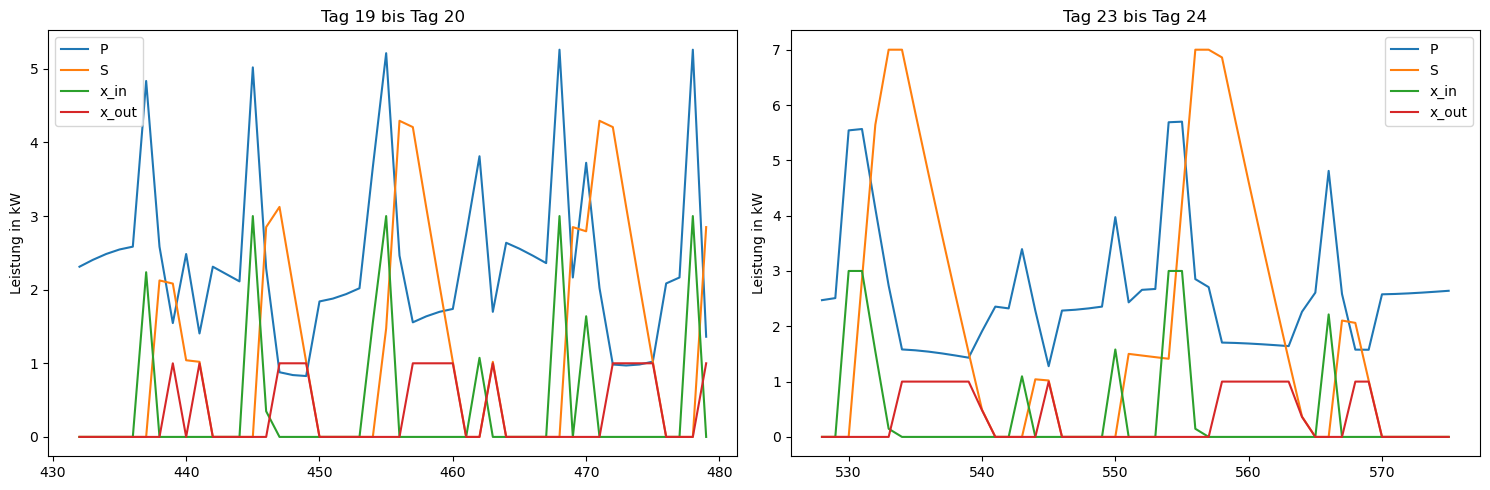

In [240]:
data = {
    'Zeit': list(range(T)),
    'P': [P[t].varValue for t in range(T)],
    'S': [S[t].varValue for t in range(T)],
    'x_in': [x_in[t].varValue for t in range(T)],
    'x_out': [x_out[t].varValue for t in range(T)],
}

df_pump = pd.DataFrame(data)

day_no_left = 19
day_no_right = 23
days_to_plot = 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df_pump[(day_no_left - 1) * 24:((day_no_left - 1) * 24) + days_to_plot * 24 ][["P", "S", "x_in", "x_out"]].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title(f"Tag {day_no_left} bis Tag {day_no_left + days_to_plot - 1}")

df_pump[(day_no_right - 1) * 24:((day_no_right - 1) * 24) + days_to_plot * 24 ][["P", "S", "x_in", "x_out"]].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_title(f"Tag {day_no_right} bis Tag {day_no_right + days_to_plot - 1}")

plt.tight_layout()
plt.show()

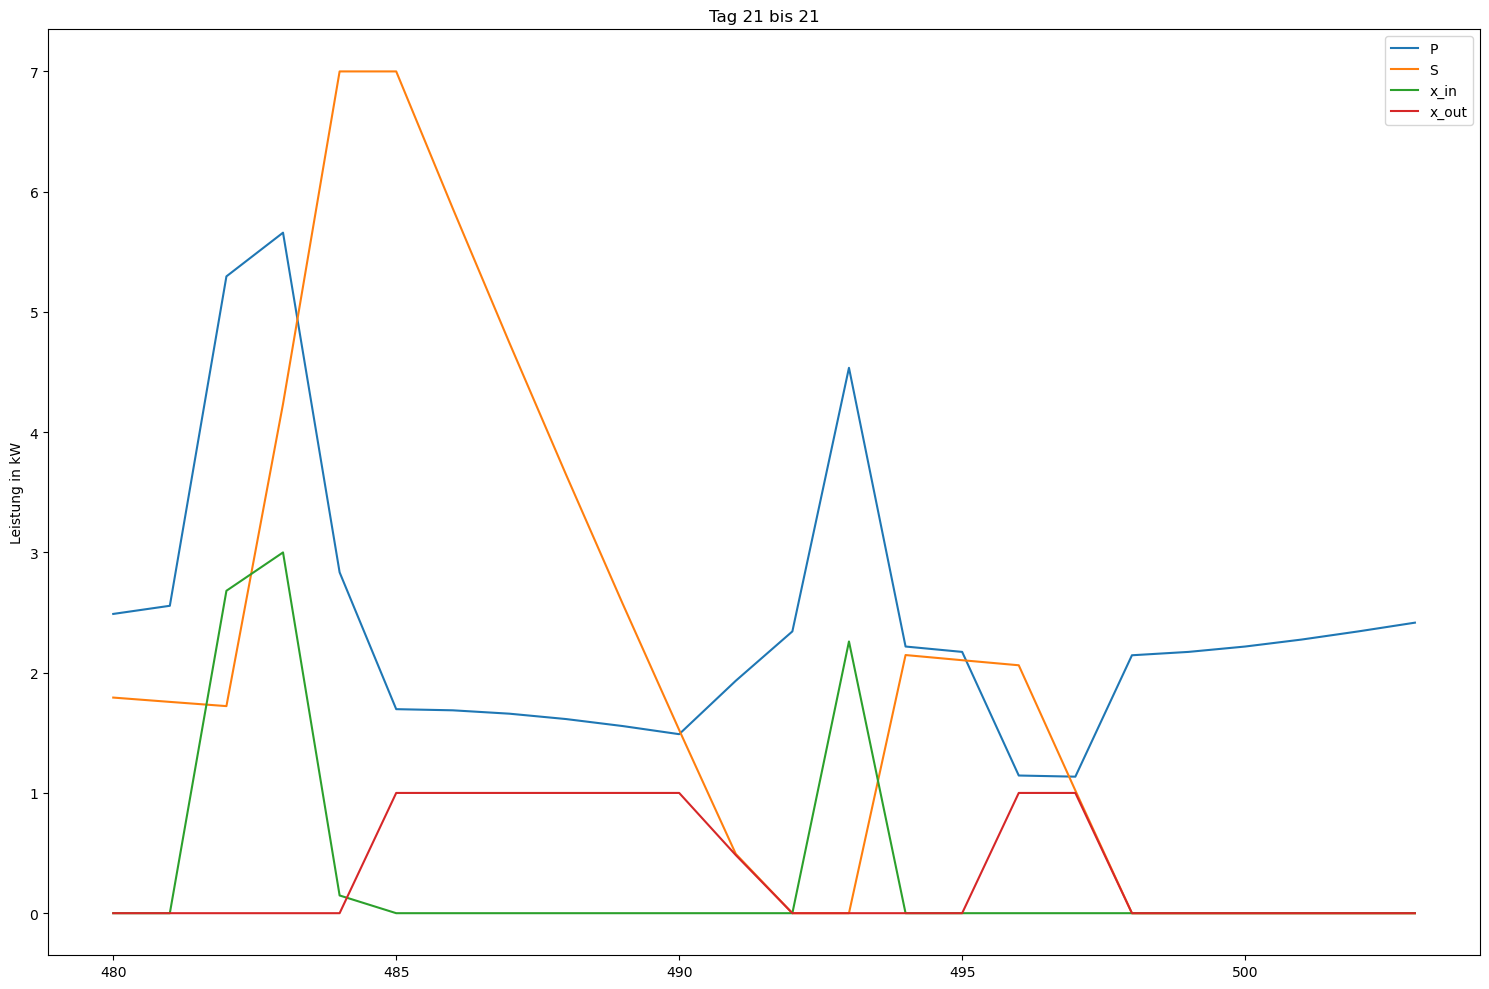

In [258]:
data = {
    'Zeit': list(range(T)),
    'P': [P[t].varValue for t in range(T)],
    'S': [S[t].varValue for t in range(T)],
    'x_in': [x_in[t].varValue for t in range(T)],
    'x_out': [x_out[t].varValue for t in range(T)],
}

df_pump = pd.DataFrame(data)

day = 21
days = 1

fig, (ax1) = plt.subplots(1, figsize=(15, 10))

df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["P", "S", "x_in", "x_out"]].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title(f"Tag {day} bis {day + days - 1}")

plt.tight_layout()
plt.show()

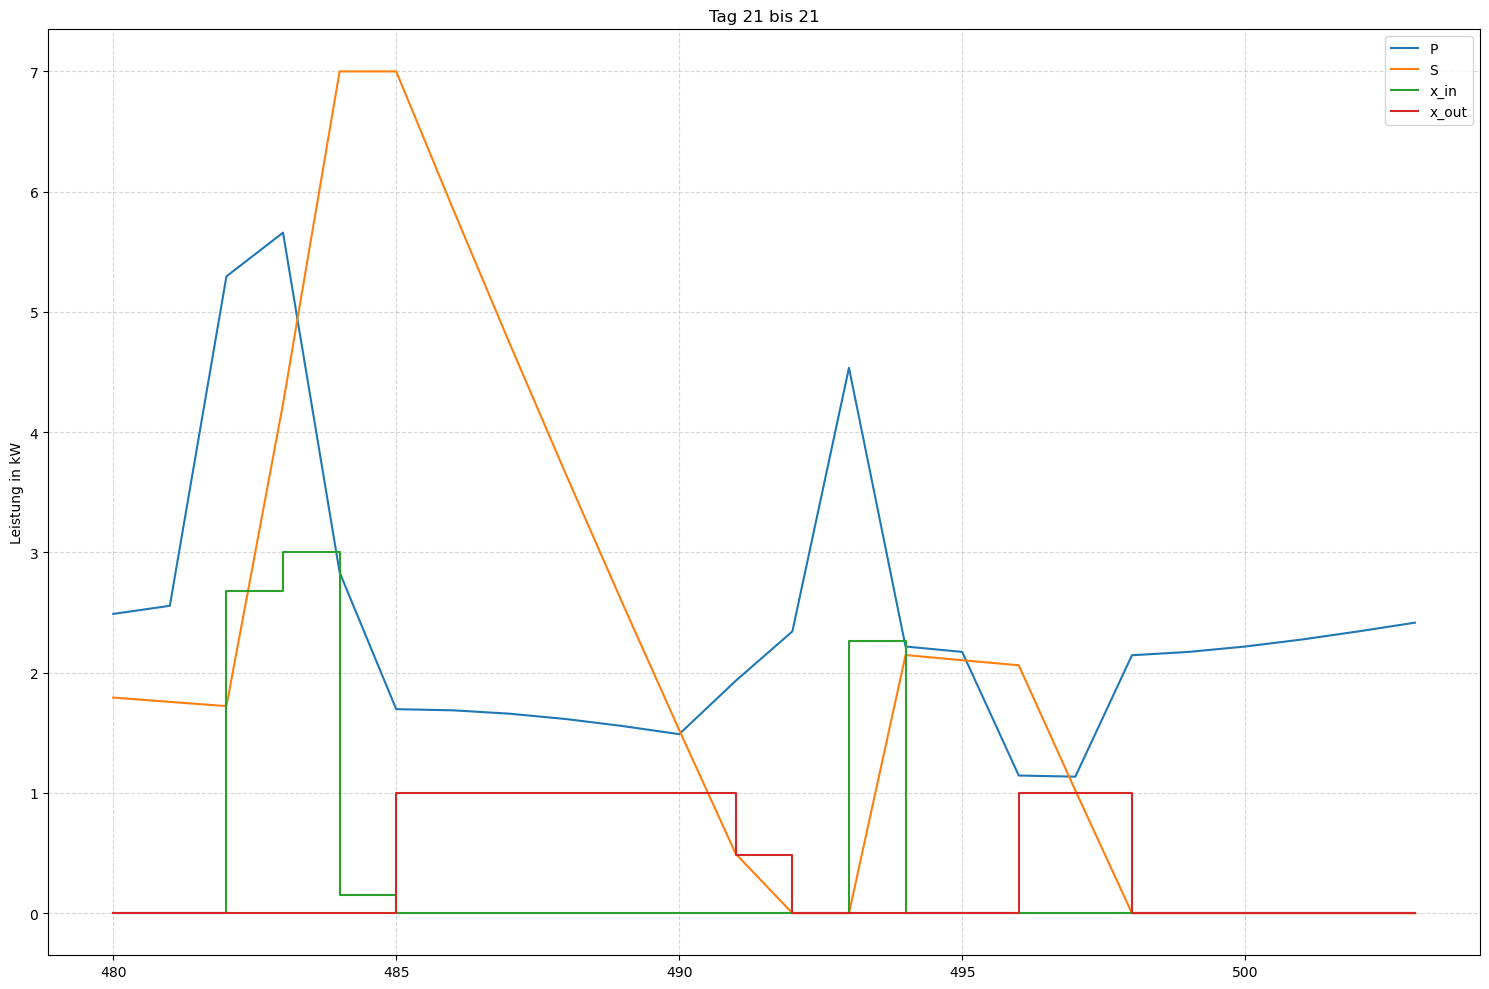

In [265]:
data = {
    'Zeit': list(range(T)),
    'P': [P[t].varValue for t in range(T)],
    'S': [S[t].varValue for t in range(T)],
    'x_in': [x_in[t].varValue for t in range(T)],
    'x_out': [x_out[t].varValue for t in range(T)],
}

df_pump = pd.DataFrame(data)

day = 21
days = 1

fig, (ax1) = plt.subplots(1, figsize=(15, 10))

df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["P", "S"]].plot(ax=ax1)
df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["x_in", "x_out"]].plot(ax=ax1, drawstyle='steps-post')

ax1.set_ylabel("Leistung in kW")
ax1.set_title(f"Tag {day} bis {day + days - 1}")

ax1.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Bestimmung der Amortisationsdauer

$$
T_{\text{Amortisation}} = \frac{\text{Anschaffungskosten}}{\text{Jährliche Ersparnis}}
$$



In [163]:
#Amortisationsdauer der Wärmepumpe ohne Pufferspeicher, ohne Basismodellerweiterung
pump_cost = 0
for demand, price in zip(Q_ges, c_t):
    pump_cost += demand * price

print("Anschaffungskosten der Wärmepumpe: ", buy_pump, "€")
print("Heizkosten ohne Wärmepumpe: ", round(heating_bill, 2), "€")
print("Heizkosten mit Wärmepumpe: ", round(pump_cost, 2), "€")
print("Einsparung durch Wärmepumpe: ", round(heating_bill - pump_cost, 2), "€")
print("Einsparungen in Prozent: ", round(((heating_bill - pump_cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_pump / (heating_bill - pump_cost), 2), "Jahre")

Anschaffungskosten der Wärmepumpe:  6000 €
Heizkosten ohne Wärmepumpe:  1730 €
Heizkosten mit Wärmepumpe:  398.14 €
Einsparung durch Wärmepumpe:  1331.86 €
Einsparungen in Prozent:  76.99 %
Amortisationsdauer in Jahren:  4.5 Jahre


In [164]:
#Amortisationsdauer von Wärmepumpe + Pufferspeicher, ohne Basismodellerweiterung
cost = p.value(model_1.objective)
buy_cost = buy_pump + buy_storage

print("Anschaffungskosten W & P: ", buy_cost, "€")
print("Heizkosten ohne W & P: ", round(heating_bill, 2), "€")
print("Heizkosten mit W & P : ", round(cost, 2), "€")
print("Einsparung durch W & P : ", round(heating_bill - cost, 2), "€")
print("Einsparungen in Prozent: ", round(((heating_bill - cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_cost / (heating_bill - cost), 2), "Jahre")


Anschaffungskosten W & P:  13800 €
Heizkosten ohne W & P:  1730 €
Heizkosten mit W & P :  359.47 €
Einsparung durch W & P :  1370.53 €
Einsparungen in Prozent:  79.22 %
Amortisationsdauer in Jahren:  10.07 Jahre


## Basismodell
Bewertung von Photovoltaik-Anlagen zur Deckung des Eigenbedarfs inkl. Batteriespeicher

In [165]:
e_slp = bdew.ElecSlp(selected_year)
elec_demand = e_slp.get_profile({"h0": yearly_demand})

In [166]:
# Erstelle ein DataFrame mit dem Lastprofil und dem Erzeugungsprofil
energiesystem = pd.DataFrame()
energiesystem["demand"] = elec_demand
energiesystem["pv"] = elec_pv["P"] / 1000 # kW

# Konvertiere in stündliche Werte
energiesystem = energiesystem.resample("h").mean()

# summe von demand und pv, gerundet ohne Kommastellen
print(f"Summe des Lastprofils: {energiesystem['demand'].sum():.0f}")
print(f"Summe des PV-Erzeugungsprofils: {energiesystem['pv'].sum():.0f}")

Summe des Lastprofils: 3000
Summe des PV-Erzeugungsprofils: 9152


Text(0.5, 1.0, 'Woche 23')

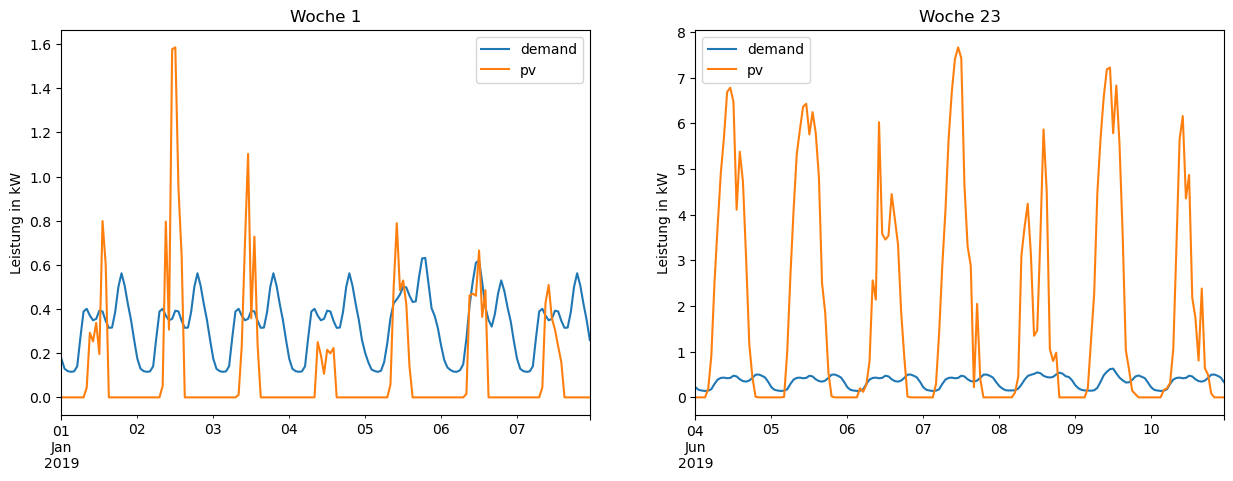

In [146]:
# Plotte das Lastprofil und das Erzeugungsprofil für zwei ausgewählte Wochen in subplots nebeneinander
week_no_left = 1
week_no_right = 23

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
energiesystem[(week_no_left-1)*24*7:week_no_left*24*7].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title("Woche " + str(week_no_left))

energiesystem[(week_no_right-1)*24*7:week_no_right*24*7].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_title("Woche " + str(week_no_right))

In [167]:
# Berechne den Eigenverbrauch
energiesystem["feedin"] = energiesystem["pv"] - energiesystem["demand"]
energiesystem["feedin"] = energiesystem["feedin"].clip(lower=0)

energiesystem["self_consumption"] = energiesystem["pv"] - energiesystem["feedin"]

energiesystem["electricity_purchase"] = energiesystem["demand"] - energiesystem["self_consumption"]

energiesystem.index.name = 't'

# Gib die Eigenverbrauchsquote aus
eigenverbrauchsquote = energiesystem["self_consumption"].sum() / energiesystem["pv"].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autharkiegrad = energiesystem["self_consumption"].sum() / energiesystem["demand"].sum() * 100
print(f"Autarkiegrad: {autharkiegrad:.0f} %")

Eigenverbrauchsquote: 16 %
Autarkiegrad: 49 %


# Aufstellung eines Optimierungsproblems

## Zielfunktion
- Minimierung der Kosten abzüglich der Einspeisevergütung
- Strombezug aus dem Netz $y^{pur}_t$
- Einspeisung in das Netz $y^{pv,feedin}_t$
- Einspeisevergütung $c^{feedin}$
- Bezugskosten $c^{pur}$
$$ \min \sum_{t=1}^{T} (y^{pur}_t \cdot c^{pur} \cdot {dt} - y^{pv,feedin}_t \cdot c^{feedin} \cdot {dt}) $$

## Nebenbedingungen
- Deckung der Nachfrage $D_t$ aus Netzbezug $y^{pur}_t$, PV Eigennutzung, $y^{pv,self}_t$ und Entladung Batterie $y^{s,dc}_t$
$$ y^{pur}_t + y^{pv,self}_t + y^{s,dc}_t - y^{s,ch}_t = D_t $$
- Aufteilung der gesamten PV-Erzeugung ${PV}_t$ in Eigennutzung $y^{pv,self}_t$ und Einspeisung $y^{pv,feedin}_t$
$$ y^{pv,self}_t + y^{pv,feedin}_t = {PV}_t $$

- Speicherfüllstandsrestriktionen (Speicherfüllstand $l^s_t$) mit Batteriekapazität $E^{bat}$, Lade-/Entladeleistung $P^{bat}$ und Wirkungsgrad $\eta_{bat}$
$$ y^{s,dc}_t <= P^{bat} $$
$$ y^{s,ch}_t <= P^{bat} $$
$$ l^s_t + y^{s,ch}_t \cdot \eta_{bat} \cdot {dt} - y^{s,dc}_t \cdot {dt} - l^s_{t+1}= 0 $$
$$ 0 <= l^s_t <= E^{bat} $$

---

## Optimierungsproblem in Pulp für Kompatibilität

In [247]:
# Variablen & Nebenbedingungen

# Erzeugt Variable für den Strombezug aus dem Netz und fügt untere Grenze hinzu
y_pur = [p.LpVariable(f"y_pur_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die PV-Eigennutzungsvariable und fügt untere Grenze hinzu
y_pv_self = [p.LpVariable(f"y_pv_self_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die PV-Einspeisungsvariable und fügt untere Grenze hinzu
y_pv_feedin = [p.LpVariable(f"y_pv_feedin_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die Batterieladung und fügt Grenzen hinzu
y_s_ch = [p.LpVariable(f"y_s_ch_{t}", lowBound=0, upBound=P_bat) for t in range(T)]

# Erzeugt Variable für die Batterientladung und fügt Grenzen hinzu
y_s_dc = [p.LpVariable(f"y_s_dc_{t}", lowBound=0, upBound=P_bat) for t in range(T)]

# Erzeugt Variable für den Batteriefüllstand und fügt Grenzen hinzu
l_s = [p.LpVariable(f"l_s_{t}", lowBound=0, upBound=E_bat) for t in range(T)]

In [248]:
# Zielfunktion
cost_grid = p.lpSum([y_pur[t] * c_pur * dt for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin * dt for t in range(T)])

objective = p.lpSum([cost_grid, -revenue_pv])

In [249]:
# Liste für aller sonstigen Nebenbedingungen
merged_constraints_1 = merged_constraints.copy()

constraints = []

# Deckung der elektrischen Nachfrage
for t in range(T):
    constraints.append(y_pur[t] + y_pv_self[t] + y_s_dc[t] - y_s_ch[t] == D_Haushalt[t])

# Dynamik des Batterie-Füllstands
for t in range(T-1):
    constraints.append(l_s[t+1] == l_s[t] + y_s_ch[t] * eta_bat * dt - y_s_dc[t] * dt)

# Anfangsfüllstand der Batterie
constraints.append(l_s[0] == l_start)

# Speichert Constraints für Modell Integration
merged_constraints_1.extend(constraints)

# Nebenbedingung, die sich im Gesamtmodell ändert, darf dementsprechend nur zum Basismodell hinzugefügt werden
for t in range(T):
    # Aufteilung der PV-Erzeugung
    constraints.append(y_pv_self[t] + y_pv_feedin[t] == PV[t])

In [250]:
# Erstelle das Optimierungsproblem
model_2 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_2 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_2 += constraint

# Löse das Problem
model_2.solve()

# Status des Modells abfragen
status = p.LpStatus[model_2.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model_2.status])
    print(f"Kosten:", round(p.value(model_2.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfung Sie ihre Eingaben!")
elif status == "Unbounded":
    print("Error! Bitte kontaktieren Sie den Support!")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juliandomnik/miniconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/m4/qcxwdmxd5b94sx7ctbs447dc0000gn/T/230fd3ec63a8405f92320c85ddf6023b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/m4/qcxwdmxd5b94sx7ctbs447dc0000gn/T/230fd3ec63a8405f92320c85ddf6023b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 26285 COLUMNS
At line 131403 RHS
At line 157684 BOUNDS
At line 183965 ENDATA
Problem MODEL has 26280 rows, 52560 columns and 87597 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17518 (-8762) rows, 39183 (-13377) columns and 65459 (-22138) elements
Perturbing problem by 0.001% of 0.059 - largest nonzero change 1.0064842e-06 ( 0.0055684601%) - largest zero change 1.0063838e-06
0  Obj 0 Primal inf 9190.0527 (8759) Dual inf 74.656742 (4148)
312  Obj -1

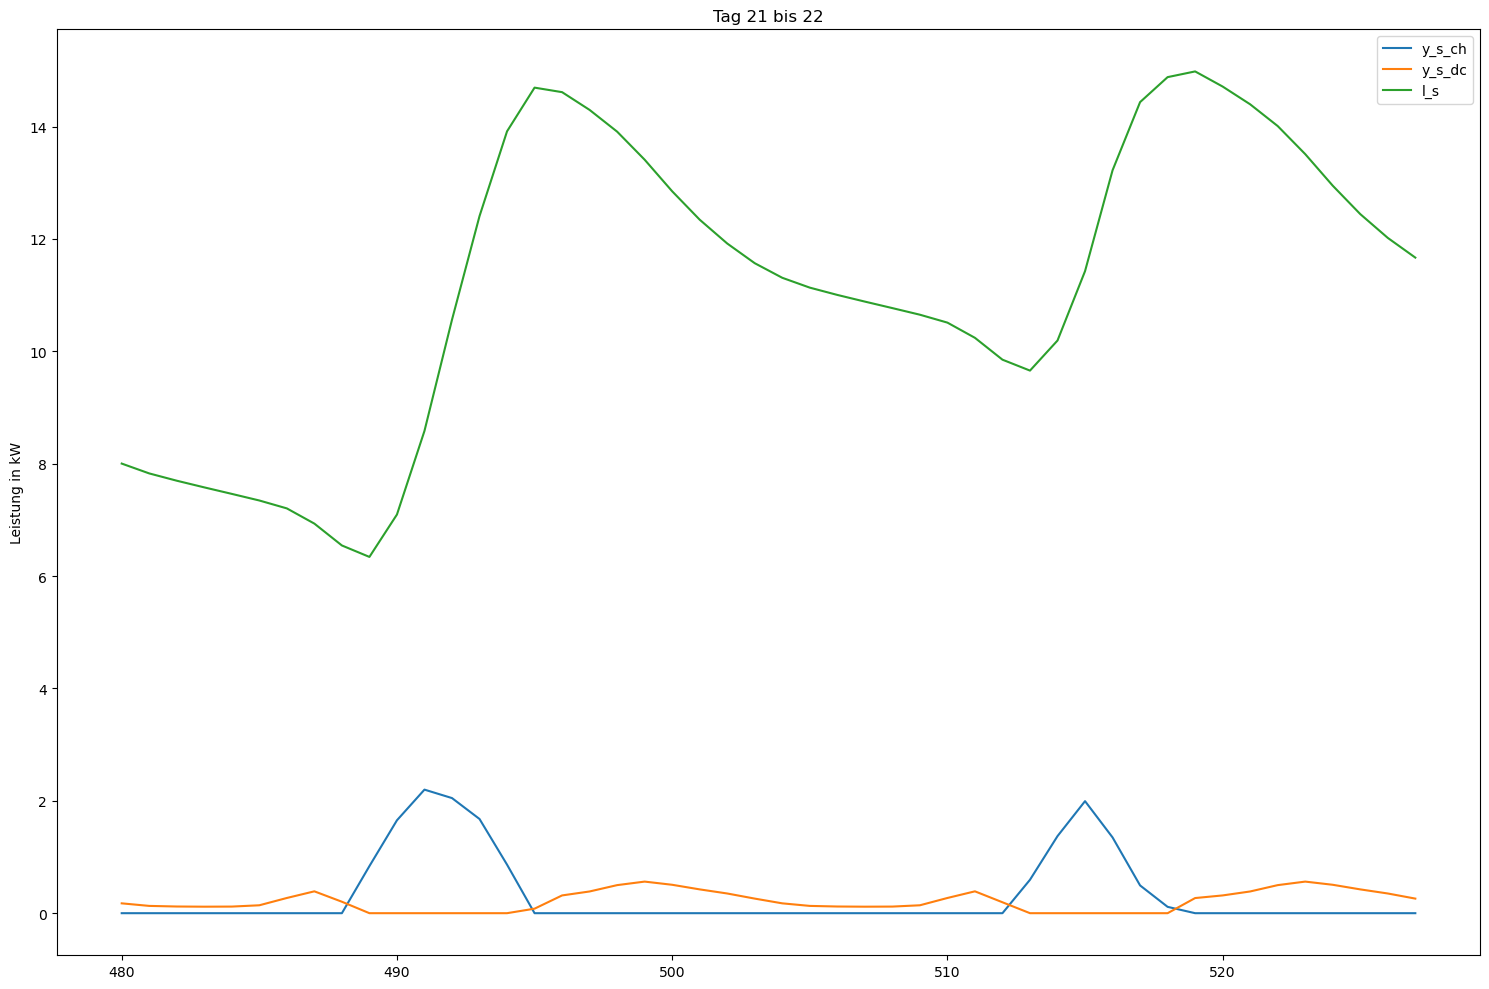

In [254]:
data = {
    'Zeit': list(range(T)),
    'y_pur': [y_pur[t].varValue for t in range(T)],
    'y_pv_self': [y_pv_self[t].varValue for t in range(T)],
    'y_pv_feedin': [y_pv_feedin[t].varValue for t in range(T)],
    'y_s_ch': [y_s_ch[t].varValue for t in range(T)],
    'y_s_dc': [y_s_dc[t].varValue for t in range(T)],
    'l_s': [l_s[t].varValue for t in range(T)]
}

df_basis = pd.DataFrame(data)

day = 21
days = 2

fig, (ax1) = plt.subplots(1, figsize=(15, 10))

df_basis[(day - 1) * 24:((day - 1) * 24) + days * 24 ][[ "y_s_ch", "y_s_dc", "l_s"]].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title(f"Tag {day} bis {day + days - 1}")

plt.tight_layout()
plt.show()

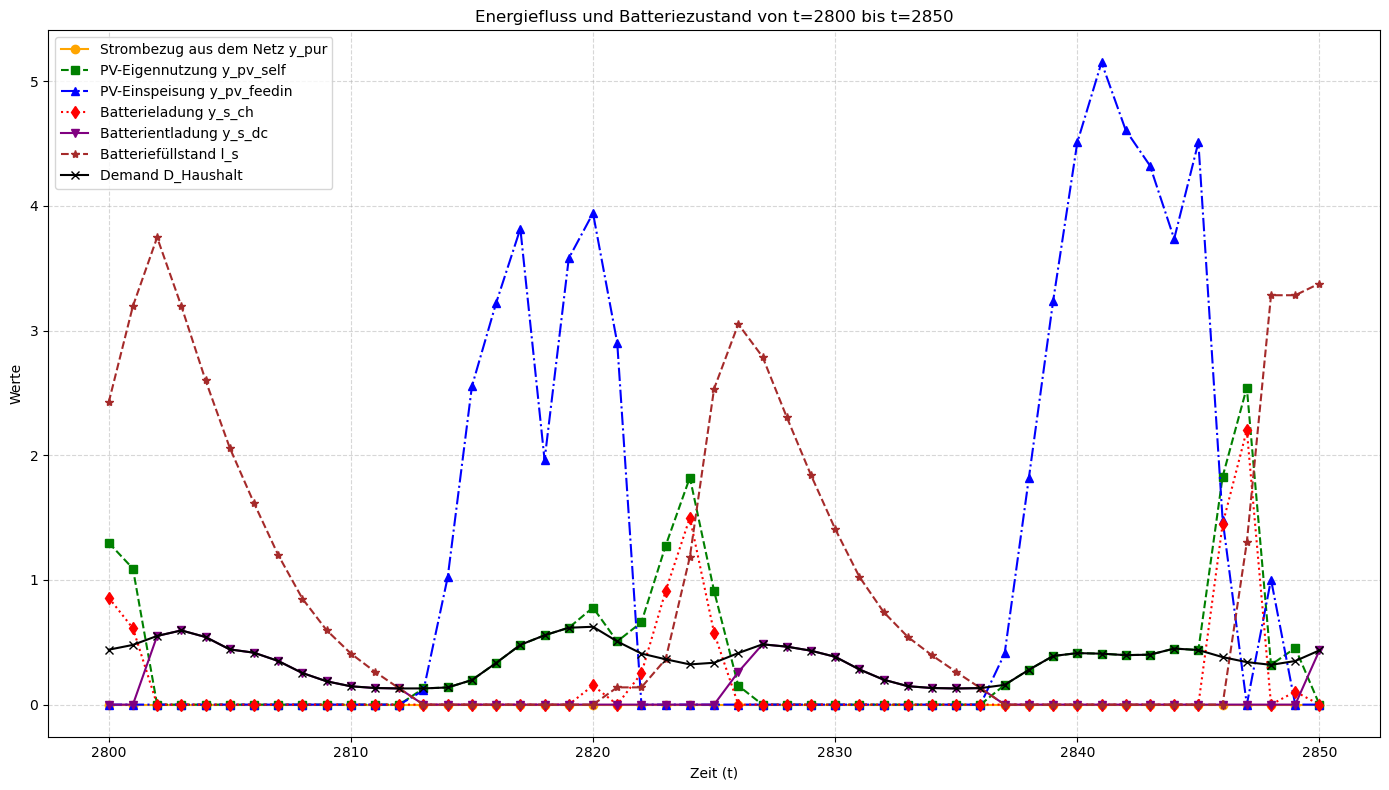

In [71]:
# Werte extrahieren
y_pur_values = [y_pur[t].varValue for t in range(T)]
y_pv_self_values = [y_pv_self[t].varValue for t in range(T)]
y_pv_feedin_values = [y_pv_feedin[t].varValue for t in range(T)]
y_s_ch_values = [y_s_ch[t].varValue for t in range(T)]
y_s_dc_values = [y_s_dc[t].varValue for t in range(T)]
l_s_values = [l_s[t].varValue for t in range(T)]
time_steps = list(range(T))

# Definiere den Bereich, den du plotten möchtest
start_t = 2800
end_t = 2850

# Überprüfen, ob der Bereich innerhalb der Daten liegt
if end_t >= T:
    raise ValueError(f"Endzeitpunkt {end_t} überschreitet die maximale Zeitperiode {T-1}.")

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_y_pur = y_pur_values[start_t:end_t+1]
sliced_y_pv_self = y_pv_self_values[start_t:end_t+1]
sliced_y_pv_feedin = y_pv_feedin_values[start_t:end_t+1]
sliced_y_s_ch = y_s_ch_values[start_t:end_t+1]
sliced_y_s_dc = y_s_dc_values[start_t:end_t+1]
sliced_l_s = l_s_values[start_t:end_t+1]
sliced_demand = D_Haushalt[start_t:end_t+1]

# Plot erstellen
plt.figure(figsize=(14, 8))

# Strombezug aus dem Netz
plt.plot(sliced_time, sliced_y_pur, marker='o', linestyle='-', color='orange', label='Strombezug aus dem Netz y_pur')
# PV-Eigennutzung
plt.plot(sliced_time, sliced_y_pv_self, marker='s', linestyle='--', color='green', label='PV-Eigennutzung y_pv_self')
# PV-Einspeisung
plt.plot(sliced_time, sliced_y_pv_feedin, marker='^', linestyle='-.', color='blue', label='PV-Einspeisung y_pv_feedin')
# Batterieladung
plt.plot(sliced_time, sliced_y_s_ch, marker='d', linestyle=':', color='red', label='Batterieladung y_s_ch')
# Batterientladung
plt.plot(sliced_time, sliced_y_s_dc, marker='v', linestyle='-', color='purple', label='Batterientladung y_s_dc')
# Batteriefüllstand
plt.plot(sliced_time, sliced_l_s, marker='*', linestyle='--', color='brown', label='Batteriefüllstand l_s')
# Demand hinzufügen
plt.plot(sliced_time, sliced_demand, marker='x', linestyle='-', color='black', label='Demand D_Haushalt')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Batteriezustand von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

In [72]:
# Gesamtkosten bei Nutzung beider Systeme ohne Systemintegration
print(f"Kosten Wärmepumpe-Modell :", round(p.value(model_1.objective), 2), "€")
print(f"Kosten Basismodell :", round(p.value(model_2.objective), 2), "€")
print(f"Gesamtkosten: ", round(p.value(model_1.objective + p.value(model_2.objective)), 2), "€")

# Ein separater Stromvertrag ist die gängige Variante zum Betrieb eine Wärmepumpe in Deutschland,
# jedoch bietet es sich an die Wärmepumpe mit der Energie aus der Batterie oder direkt aus der PV-Produktion zu betreiben.
# Damit werden neue Variablen & Nebenbedingungen benötigt, um die Kommunikation beider Modelle abzubilden.

Kosten Wärmepumpe-Modell : 172.58 €
Kosten Basismodell : -98.64 €
Gesamtkosten:  73.94 €


## Fusion beider Modelle

In [73]:
# Neue Variablen aus Kombination beider Modelle

# Erzeugt Variable für den Wärmepumpenstrombezug durch Batterie und fügt Grenzen hinzu
y_heat_bat = [p.LpVariable(f"y_heat_bat_{t}", lowBound=0, upBound=l_s[t]) for t in range(T)]

# Erzeugt Variable für den Wärmepumpenstrombezug durch PV-Anlage und fügt Grenzen
y_heat_pv = [p.LpVariable(f"y_heat_pv_{t}", lowBound=0, upBound=PV[t]) for t in range(T)]

# Erzeugt Variable für den Wärmepumpenstrombezug durch Stromanbierter
y_heat_pur = [p.LpVariable(f"factor{t}", lowBound=0) for t in range(T)]

In [74]:
# Zielfunktion: Minimierung der Gesamtkosten
# Kosten der Wärmepumpe + Kosten für Strombezug - Einnahmen durch PV-Einspeisung

cost_grid = p.lpSum([y_pur[t] * c_pur * dt for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin * dt for t in range(T)])
cost_pump = p.lpSum([c_t[t] * y_heat_pur[t] for t in range(T)])

objective = p.lpSum([cost_pump, cost_grid, -revenue_pv])

In [75]:
#Komplexere Nebenbedingungen (nicht nur obere und untere Begrenzungen)
merged_constraints_2 = merged_constraints_1.copy()

for t in range(T):
    merged_constraints_2.append(P[t] == y_heat_pur[t] + y_heat_bat[t] + y_heat_pv[t])

    # Aufteilung der PV-Erzeugung
    merged_constraints_2.append(y_pv_self[t] + y_pv_feedin[t] + y_heat_pv[t] == PV[t])



In [89]:
# Erstelle das Optimierungsproblem
model = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model += objective

# Füge alle Nebenbedingungen hinzu
for constraint in merged_constraints_2:
    model += constraint

# Löse das Problem
model.solve()

# Status des Modells abfragen
status = p.LpStatus[model.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model.status])
    print(f"Kosten Systemintegration: ", round(p.value(model.objective), 2), "€")
    print(f"Kosten getrennte Systeme: ", round(p.value(model_1.objective) + p.value(model_2.objective), 2), "€")
    print(f"Einsparung durch Systemintegration:", round((p.value(model_1.objective) + p.value(model_2.objective) - p.value(model.objective)), 2), "€")
    print(f"Einsparung durch Systemintegration in Prozent:", round((p.value(model_1.objective) + p.value(model_2.objective) - p.value(model.objective))/(p.value(model_1.objective) + p.value(model_2.objective)) * 100, 2), "%")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfung Sie ihre Eingaben!")
else:
    print("Error, bitte kontaktieren Sie den Support!")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juliandomnik/miniconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/m4/qcxwdmxd5b94sx7ctbs447dc0000gn/T/5c4b9e88eb784664a5f163d06fffd3e1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/m4/qcxwdmxd5b94sx7ctbs447dc0000gn/T/5c4b9e88eb784664a5f163d06fffd3e1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 52565 COLUMNS
At line 271561 RHS
At line 324122 BOUNDS
At line 402963 ENDATA
Problem MODEL has 52560 rows, 113880 columns and 192716 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 38244 (-14316) rows, 81218 (-32662) columns and 140187 (-52529) elements
Perturbing problem by 0.001% of 0.20497684 - largest nonzero change 1.0211197e-06 ( 7.77766%) - largest zero change 1.0211083e-06
0  Obj 48.18473 Primal inf 15716.199 (19561) Dual inf 119.78933 (4929)

Zeit 450:
  Wärmeleistung P_450: 0.75561847
  Speicherfüllstand S_450: 0.20140748
  Ladeleistung x_in_450: 0.0
  Entladeleistung x_out_450: 0.19737933

Zeit 451:
  Wärmeleistung P_451: 0.97292793
  Speicherfüllstand S_451: 0.0
  Ladeleistung x_in_451: 0.0
  Entladeleistung x_out_451: 0.0

Zeit 452:
  Wärmeleistung P_452: 1.0046322
  Speicherfüllstand S_452: 0.0
  Ladeleistung x_in_452: 0.0
  Entladeleistung x_out_452: 0.0

Zeit 453:
  Wärmeleistung P_453: 1.04595
  Speicherfüllstand S_453: 0.0
  Ladeleistung x_in_453: 0.0
  Entladeleistung x_out_453: 0.0

Zeit 454:
  Wärmeleistung P_454: 2.6452715
  Speicherfüllstand S_454: 0.0
  Ladeleistung x_in_454: 1.5512059
  Entladeleistung x_out_454: 0.0

Zeit 455:
  Wärmeleistung P_455: 4.1457
  Speicherfüllstand S_455: 1.4736456
  Ladeleistung x_in_455: 3.0
  Entladeleistung x_out_455: 0.0

Zeit 456:
  Wärmeleistung P_456: 1.275022
  Speicherfüllstand S_456: 4.2941727
  Ladeleistung x_in_456: 0.0
  Entladeleistung x_out_456: 0.0

Zeit 457:
  W

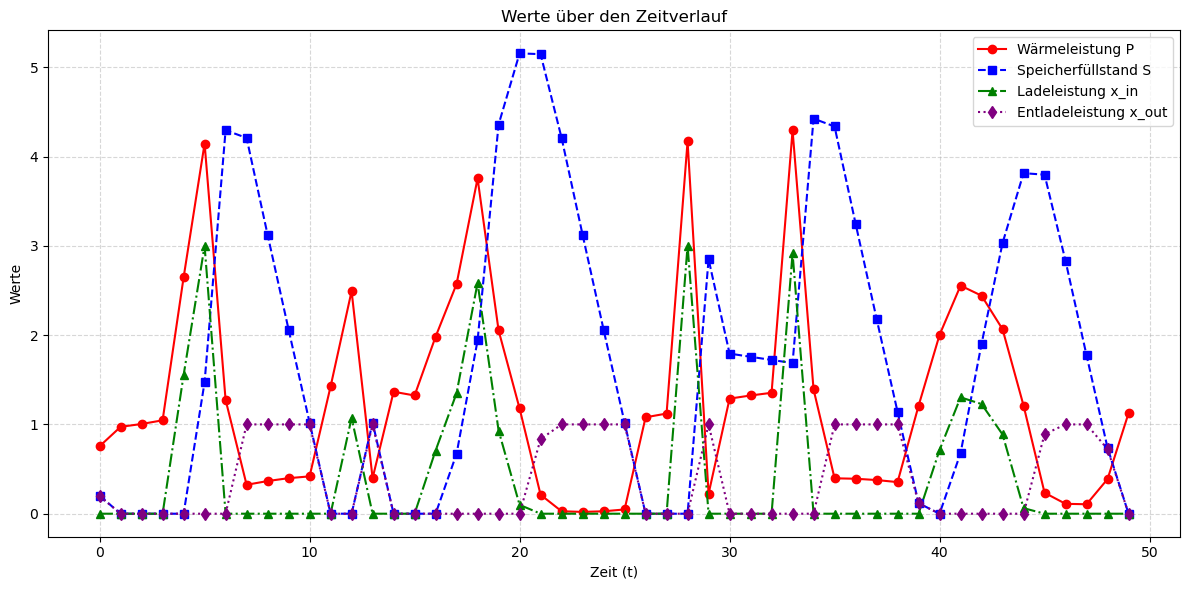

In [77]:
# Listen zur Speicherung der Werte
P_values = []
S_values = []
x_in_values = []
x_out_values = []
time_steps = list(range(50))

# Werte extrahieren
for t in range(450,500):
    P_values.append(P[t].varValue)
    S_values.append(S[t].varValue)
    x_in_values.append(x_in[t].varValue)
    x_out_values.append(x_out[t].varValue)

    # Optional: Ausgabe in der Konsole
    print(f"Zeit {t}:")
    print(f"  Wärmepumpeleistung P_{t}: {P[t].varValue}")
    print(f"  Speicherfüllstand S_{t}: {S[t].varValue}")
    print(f"  Ladeleistung x_in_{t}: {x_in[t].varValue}")
    print(f"  Entladeleistung x_out_{t}: {x_out[t].varValue}\n")

# Plot erstellen
plt.figure(figsize=(12, 6))

plt.plot(time_steps, P_values, marker='o', linestyle='-', color='red', label='Wärmeleistung P')
plt.plot(time_steps, S_values, marker='s', linestyle='--', color='blue', label='Speicherfüllstand S')
plt.plot(time_steps, x_in_values, marker='^', linestyle='-.', color='green', label='Ladeleistung x_in')
plt.plot(time_steps, x_out_values, marker='d', linestyle=':', color='purple', label='Entladeleistung x_out')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title('Werte über den Zeitverlauf')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Diagramm anzeigen
plt.tight_layout()
plt.show()

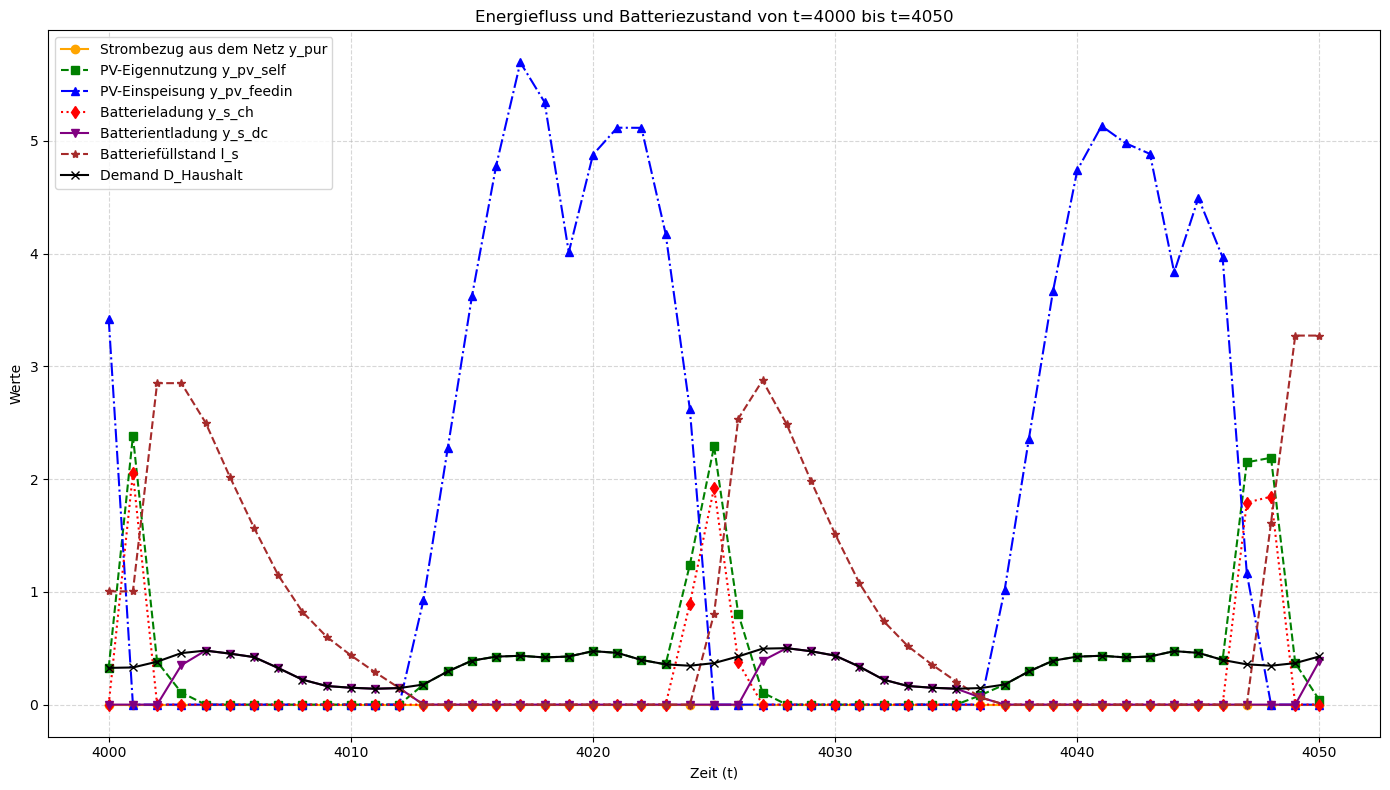

In [85]:
# Werte extrahieren
y_pur_values = [y_pur[t].varValue for t in range(T)]
y_pv_self_values = [y_pv_self[t].varValue for t in range(T)]
y_pv_feedin_values = [y_pv_feedin[t].varValue for t in range(T)]
y_s_ch_values = [y_s_ch[t].varValue for t in range(T)]
y_s_dc_values = [y_s_dc[t].varValue for t in range(T)]
l_s_values = [l_s[t].varValue for t in range(T)]
time_steps = list(range(T))

# Definiere den Bereich, den du plotten möchtest
start_t = 4000
end_t = 4050

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_y_pur = y_pur_values[start_t:end_t+1]
sliced_y_pv_self = y_pv_self_values[start_t:end_t+1]
sliced_y_pv_feedin = y_pv_feedin_values[start_t:end_t+1]
sliced_y_s_ch = y_s_ch_values[start_t:end_t+1]
sliced_y_s_dc = y_s_dc_values[start_t:end_t+1]
sliced_l_s = l_s_values[start_t:end_t+1]
sliced_demand = D_Haushalt[start_t:end_t+1]

# Plot erstellen
plt.figure(figsize=(14, 8))

# Strombezug aus dem Netz
plt.plot(sliced_time, sliced_y_pur, marker='o', linestyle='-', color='orange', label='Strombezug aus dem Netz y_pur')
# PV-Eigennutzung
plt.plot(sliced_time, sliced_y_pv_self, marker='s', linestyle='--', color='green', label='PV-Eigennutzung y_pv_self')
# PV-Einspeisung
plt.plot(sliced_time, sliced_y_pv_feedin, marker='^', linestyle='-.', color='blue', label='PV-Einspeisung y_pv_feedin')
# Batterieladung
plt.plot(sliced_time, sliced_y_s_ch, marker='d', linestyle=':', color='red', label='Batterieladung y_s_ch')
# Batterientladung
plt.plot(sliced_time, sliced_y_s_dc, marker='v', linestyle='-', color='purple', label='Batterientladung y_s_dc')
# Batteriefüllstand
plt.plot(sliced_time, sliced_l_s, marker='*', linestyle='--', color='brown', label='Batteriefüllstand l_s')
# Demand hinzufügen
plt.plot(sliced_time, sliced_demand, marker='x', linestyle='-', color='black', label='Demand D_Haushalt')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Batteriezustand von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

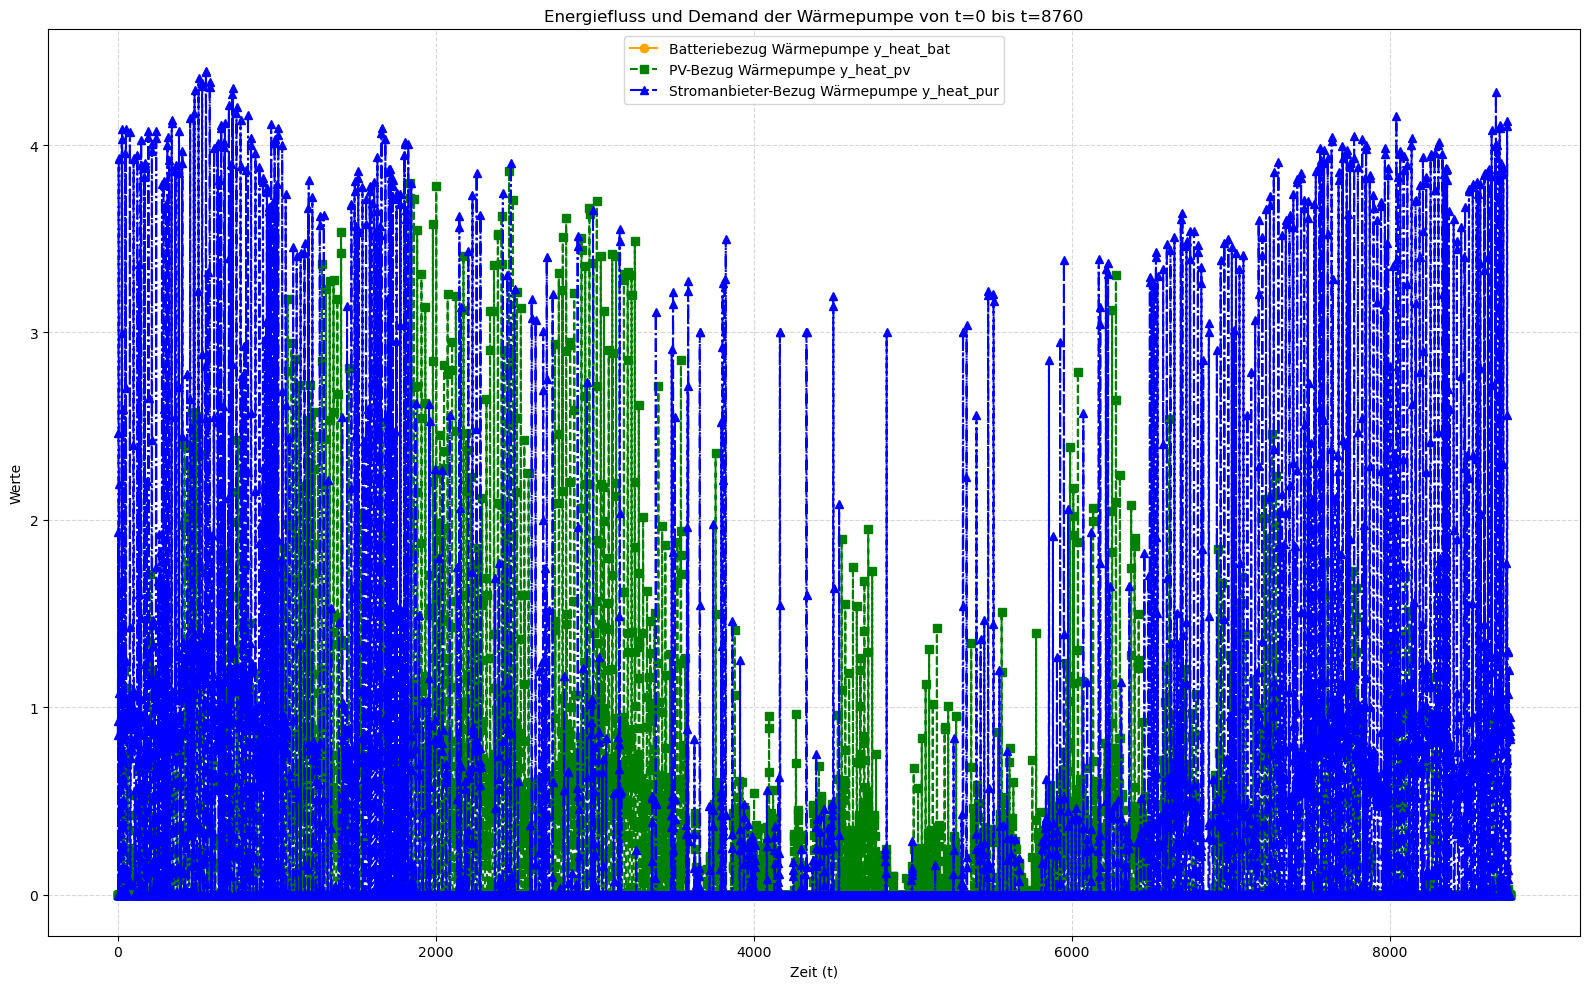

In [86]:
# Werte extrahieren
y_heat_bat_values = [y_heat_bat[t].varValue for t in range(T)]
y_heat_pv_values = [y_heat_pv[t].varValue for t in range(T)]
y_heat_pur_values = [y_heat_pur[t].varValue for t in range(T)]
time_steps = list(range(T))

# Definiere den Bereich, den du plotten möchtest
start_t = 0
end_t = T

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_y_heat_bat = y_heat_bat_values[start_t:end_t+1]
sliced_y_heat_pv = y_heat_pv_values[start_t:end_t+1]
sliced_y_heat_pur = y_heat_pur_values[start_t:end_t+1]


# Plot erstellen
plt.figure(figsize=(16, 10))

# Batteriebezug der Wärmepumpe
plt.plot(sliced_time, sliced_y_heat_bat, marker='o', linestyle='-', color='orange', label='Batteriebezug Wärmepumpe y_heat_bat')
# PV-Bezug der Wärmepumpe
plt.plot(sliced_time, sliced_y_heat_pv, marker='s', linestyle='--', color='green', label='PV-Bezug Wärmepumpe y_heat_pv')
# Stromanbieter-Bezug der Wärmepumpe
plt.plot(sliced_time, sliced_y_heat_pur, marker='^', linestyle='-.', color='blue', label='Stromanbieter-Bezug Wärmepumpe y_heat_pur')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Energiefluss und Demand der Wärmepumpe von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


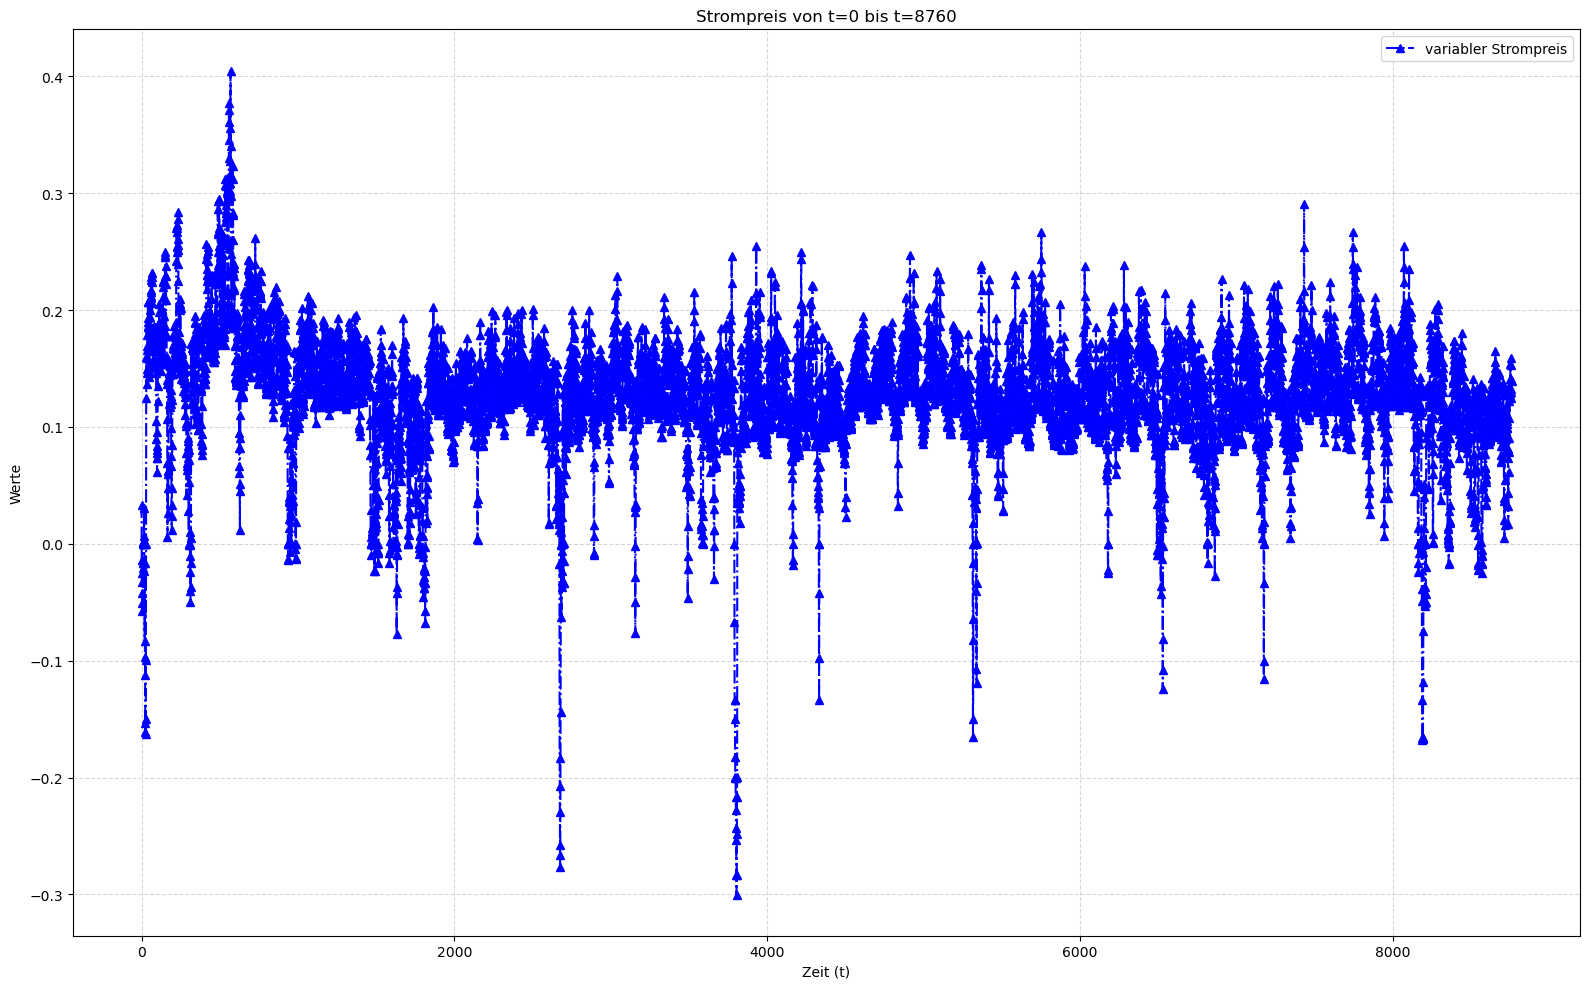

In [80]:
# Definiere den Bereich, den du plotten möchtest
start_t = 0
end_t = T

# Slice die Daten für den gewünschten Bereich
sliced_time = time_steps[start_t:end_t+1]
sliced_strompreis = Strompreise[start_t:end_t+1]
time_steps = list(range(T))

# Plot erstellen
plt.figure(figsize=(16, 10))

plt.plot(sliced_time, sliced_strompreis , marker='^', linestyle='-.', color='blue', label='variabler Strompreis')

# Achsenbeschriftungen und Titel
plt.xlabel('Zeit (t)')
plt.ylabel('Werte')
plt.title(f'Strompreis von t={start_t} bis t={end_t}')

# Legende
plt.legend()

# Gitter hinzufügen für bessere Lesbarkeit
plt.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

Über den gesamten Zeitverlauf wird nie Energie aus der Batterie für den Betrieb der Wärmepumpe entnommen. Dies ist die optimale Lösung und lässt sich durch die zwei verschiedenen Stromtarife erklären. Der variable Stromtarif scheint zu jedem Zeitpunkt günstiger zu sein, als der Strombezug im Basismodell. Deshalb ist es immer besser den Strombedarf der Wärmepumpe mit dem variablen Stromtarif zu decken, damit der Haushalt die volle Batterieelektrizität nutzen kann, um den Strombezug über den teuren Stromtarif zu meiden.

In [81]:
# Mini-Exkurs Lineare Algebra / Veranschaulichung des Problems
print("Modelldimensionen: " + str(len(model.constraints)) + " x "+ str(len(model.variables())))
print("------------------")
print("Anzahl der Constraints (m):", len(model.constraints))
print("Anzahl der Variablen (n):", len(model.variables()))

Modelldimensionen: 52560 x 113880
------------------
Anzahl der Constraints (m): 52560
Anzahl der Variablen (n): 113880


# Matrixdarstellung

## Der Solver stellt eine Matrix der Dimension MxN auf
- M: Anzahl der Nebenbedingungen (6 Nebenbedingung * 8760 Zeiteinheiten = 52560 Nebenbedingungen)
- N: Anzahl der Variablen (13 Variablen * 8760 Zeiteinheiten = 113880 Variablen)
\
\begin{aligned}
A_{MxN} &=
  \begin{pmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} & \cdots & a_{1,N} \\
    a_{2,1} & a_{2,2} & a_{2,3} & \cdots & a_{2,N} \\
    a_{3,1} & a_{3,2} & a_{3,3} & \cdots & a_{3,N} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    a_{M,1} & a_{M,2} & a_{M,3} & \cdots & a_{M,N} \\
  \end{pmatrix}
\end{aligned}









In [93]:
#Amortisationsdauer der Wärmepumpe ohne Pufferspeicher & ohne Basismodellerweiterung
pump_cost = 0
for demand, price in zip(Q_ges, c_t):
    pump_cost += demand * price

print("Anschaffungskosten der Wärmepumpe: ", buy_pump, "€")
print("Heizkosten ohne Wärmepumpe: ", round(heating_bill, 2), "€")
print("Heizkosten mit Wärmepumpe: ", round(pump_cost, 2), "€")
print("Einsparung durch Wärmepumpe: ", round(heating_bill - pump_cost, 2), "€")
print("Einsparungen in Prozent: ", round(((heating_bill - pump_cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_pump / (heating_bill - pump_cost), 2), "Jahre")

Anschaffungskosten der Wärmepumpe:  6000 €
Heizkosten ohne Wärmepumpe:  2370 €
Heizkosten mit Wärmepumpe:  206.19 €
Einsparung durch Wärmepumpe:  2163.81 €
Einsparungen in Prozent:  91.3 %
Amortisationsdauer in Jahren:  2.77 Jahre


In [94]:
#Amortisationsdauer des Wärmepumpe (integriertes Modell)
pump_cost = p.value(model_1.objective)

print("Anschaffungskosten der Wärmepumpe: ", buy_pump, "€")
print("Heizkosten ohne Wärmepumpe: ", round(heating_bill, 2), "€")
print("Heizkosten mit Wärmepumpe: ", round(pump_cost, 2), "€")
print("Einsparung durch Wärmepumpe: ", round(heating_bill - pump_cost, 2), "€")
print("Einsparungen in Prozent: ", round(((heating_bill - pump_cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_pump / (heating_bill - pump_cost), 2), "Jahre")

Anschaffungskosten der Wärmepumpe:  6000 €
Heizkosten ohne Wärmepumpe:  2370 €
Heizkosten mit Wärmepumpe:  182.81 €
Einsparung durch Wärmepumpe:  2187.19 €
Einsparungen in Prozent:  92.29 %
Amortisationsdauer in Jahren:  2.74 Jahre


In [83]:
#Durchschnittliche Amortisationsdauer bei Anschaffung von Wärmepumpe & Pufferspeicher